# Process Steps

1. Merge All tables from source A 
2. Merge All Tables from source B
3. Heat map entitys to find dense columns
4. Join columns city+ state+ zip code as one 
5. Clean the features being used by removing special characters and white space
6. Create Block feature of the first 4 chars in the name 
7. use recordlinkage package to compute all possible match pairs for each record in Source A.
8. use jarowinkler distance with threshold of .85 to match name and city_state_zip
9. Filter the matchs for only those that match within threshold .85 for name and city_state_zip or those two and area_code
10. merge source A to the _record_mapping_index and then to source B
11. output entity: 'vendor_id','b_entity_id' to csv file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
begin_time = time.time()

In [2]:
#Read in the Data
a_company = pd.read_csv('./data/a__company.csv')
a_geo = pd.read_csv('./data/a__geo.csv')
b_company = pd.read_csv('./data/b__company.csv')
b_address = pd.read_csv('./data/b__address.csv')
b_hierarchy = pd.read_csv('./data/b__hierarchy.csv')

C:\Users\Michael\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Join all Entites of source A
a_all = a_company.merge(a_geo,how='left',left_on='geo_id',right_on='geo_id')
#a_all.head(3)

In [4]:
#Join all Entites of source B
b_all = b_company.merge(b_address,how='left',left_on='b_entity_id',right_on='b_entity_id')
#b_all.head(3)

In [5]:
# Convert to String and Remove NaN from features and make all lower case.
a_all['name'] = a_all['name'].fillna('').astype('str').str.lower() 
a_all['city'] = a_all['city'].fillna('').astype('str').str.lower() 
a_all['state'] = a_all['state'].fillna('').astype('str').str.lower()
a_all['zipcode_y'] = a_all['zipcode_y'].fillna('').astype('str').str.lower()
b_all['entity_name'] = b_all['entity_name'].fillna('').astype('str').str.lower()
b_all['city_state_zip'] = b_all['city_state_zip'].fillna('').astype('str').str.lower()

In [6]:
#clean_names: will remove special characters, whitespace.
def clean_names(name):
    return ''.join(e for e in name if e.isalnum())

#Run clean_names on the name entities
a_all['a_clean_name'] = a_all['name'].apply(clean_names)
b_all['b_clean_name'] = b_all['entity_name'].apply(clean_names)

#Transform features to create  city_state_zip
a_all['a_city_state_zip'] = a_all['city']+a_all['state']+a_all['zipcode_y']
b_all['b_city_state_zip'] = b_all['city_state_zip']

#Clean the new city_state_zip feature
a_all['a_city_state_zip'] = a_all['a_city_state_zip'].apply(clean_names)
b_all['b_city_state_zip']  = b_all['b_city_state_zip'].apply(clean_names)

#Clean the Area Code
a_all['area_code'] = a_all['area_code'].fillna('')
b_all['tele_area'] = b_all['tele_area'].fillna('')

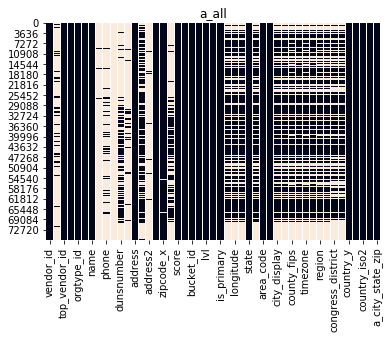

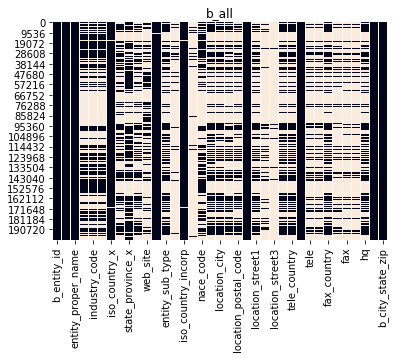

In [7]:
# Visualize Missing Data from A and B to help understand what features we can use.
sns.heatmap(a_all.isnull(), cbar=False).set_title('a_all')
plt.show()
sns.heatmap(b_all.isnull(), cbar=False).set_title('b_all')
plt.show()

In [8]:
#a_all.to_csv('a_all.csv') #Send all Data to file
#b_all.to_csv('b_all.csv') #Send all Data to file

In [9]:
#Add Blocking Features to A and B
a_all['blocks'] = a_all['a_clean_name'].str[0:4]
#_all['blocks']
b_all['blocks'] = b_all['b_clean_name'].str[0:4]
#b_all['blocks']

In [10]:
import recordlinkage

#Make record pairs
indexer = recordlinkage.Index()
indexer.block('blocks')
candidate_links = indexer.index(a_all,b_all)
print(len(candidate_links))

63649784


In [11]:
#Run Algo on Pairs
begin_time_match = time.time()
compare_cl = recordlinkage.Compare()
#jarowinkler or levenshtein
compare_cl.string('a_clean_name','b_clean_name',method='jarowinkler',threshold = .85,label='clean_name')
compare_cl.string('a_city_state_zip','b_city_state_zip',method='jarowinkler',threshold = .85,label='city_state_zip')
compare_cl.exact('area_code','tele_area',label='area_code')
features = compare_cl.compute(candidate_links,a_all,b_all)


In [27]:
end_time_match = time.time()
print('Elapsed time is %f minutes\n' %float((end_time_match-begin_time_match)/60))

Elapsed time is 21.166667 minutes



In [13]:
matches = features.reset_index()
#matches.head()

In [14]:
df = matches[(((matches['clean_name']+matches['city_state_zip']+matches['area_code'])==3))
             | ((matches['clean_name']+matches['city_state_zip'])==2)]
print(len(df))
df.head(5)

28492


,level_0,level_1,clean_name,city_state_zip,area_code
95,7090,117874,1.0,1.0,0
648,48059,117874,1.0,1.0,0
17447,214,37522,1.0,1.0,0
34287,299,58968,1.0,1.0,1
35654,299,169227,1.0,1.0,0


In [15]:
a_all.loc[7090,['a_clean_name','a_city_state_zip']] # Example Match from Table A

a_clean_name                  lhasallc
a_city_state_zip    newtoncenterma2459
Name: 7090, dtype: object

In [16]:
b_all.loc[117874,['b_clean_name','b_city_state_zip']] # Example Match from Table B

b_clean_name                 lhasallc
b_city_state_zip    newtonma024593604
Name: 117874, dtype: object

In [17]:
#Merge Table A with the multiindex mapping and table B
output = a_all.merge(df,left_index=True,right_on='level_0')
output=output.merge(b_all,how='left',left_on='level_1',right_index=True)
output.columns

Index(['vendor_id', 'parent_vendor_id', 'top_vendor_id', 'cnt_children',
       'orgtype_id', 'geo_id', 'name', 'email', 'phone', 'fax_x', 'dunsnumber',
       'websiteurl', 'address', 'address1', 'address2', 'country_x',
       'zipcode_x', 'parentdunsnumber', 'score', 'cnt_opp', 'bucket_id',
       'load_date', 'lvl', 'zipcode_y', 'is_primary', 'latitude', 'longitude',
       'elevation', 'state', 'state_full_name', 'area_code_x', 'city',
       'city_display', 'county', 'county_fips', 'state_fips', 'timezone',
       'daylight_saving', 'region', 'division', 'congress_district',
       'congress_land_area', 'country_y', 'continent', 'country_iso2',
       'a_clean_name', 'a_city_state_zip', 'blocks_x', 'level_0', 'level_1',
       'clean_name', 'city_state_zip_x', 'area_code_y', 'b_entity_id',
       'entity_name', 'entity_proper_name', 'primary_sic_code',
       'industry_code', 'sector_code', 'iso_country_x', 'metro_area',
       'state_province_x', 'zip_postal_code', 'web_site', '

In [18]:
print(len(output)) # Length of final output
output.loc[:,['a_city_state_zip','b_city_state_zip','a_clean_name','b_clean_name','level_0','level_1']].head(5)

28492


,a_city_state_zip,b_city_state_zip,a_clean_name,b_clean_name,level_0,level_1
10779943,helenamt59604,helenamt59623,lewisclarkcountyof,lewisclarkcountyofmt,6,33175
21364744,lafayettein47901,lafayettein47902,lafayettecityof,lafayettebancorpin,10,496
21364746,lafayettein47901,lafayettein479011301,lafayettecityof,lafayettecommunitybancorp,10,706
21364855,lafayettein47901,lafayettein47905,lafayettecityof,lafayettelifeinsuranceco,10,27812
21364901,lafayettein47901,lafayetteca94549,lafayettecityof,lafayettechamberofcommerce,10,39793


In [19]:
#Final Mapping
output[['vendor_id','b_entity_id']].to_csv('mapping.csv',index=False)
       
# A more detailed File
output.loc[:,['a_city_state_zip','b_city_state_zip','a_clean_name','b_clean_name',\
              'area_code_x','tele_area','level_0','level_1']].to_csv('output_detail.csv',index=False)

In [25]:
end_time = time.time()
print('Elapsed time is %f minutes\n' %float((end_time-begin_time)/60))

Elapsed time is 23.133333 minutes

